In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import  SMOTE
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from torchmetrics.classification import MulticlassF1Score, MulticlassAccuracy, MulticlassPrecision, MulticlassRecall
import thesis_models
from itertools import zip_longest

c:\Users\ellom\miniconda3\envs\pytorch-gpu-nlp\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] 找不到指定的程序。
  warn(f"Failed to load image Python extension: {e}")


In [26]:
# print(torch.__version__)

In [2]:
#Define File Path
vec20avg_path = "./vec_data/vec20_avg.npz"
vec25avg_path = "./vec_data/vec25_avg.npz"
vec30avg_path = "./vec_data/vec30_avg.npz"
vec35avg_path = "./vec_data/vec35_avg.npz"
vec20sum_path = "./vec_data/vec20_sum.npz"
vec20sum_path = "./vec_data/vec20_sum.npz"
vec25sum_path = "./vec_data/vec25_sum.npz"
vec30sum_path = "./vec_data/vec30_sum.npz"
vec35sum_path = "./vec_data/vec35_sum.npz"
# freq_stance_labels = "./vec_data/freq_stance_labels.npz"
# oh_stance_labels = "./vec_data/oh_stance_labels.npz"
le_stance_labels = "./vec_data/le_stance_labels.npz"

In [3]:
def load_npz_file(filepath):
    # Load the numpy array from the .npz file
    with np.load(filepath, allow_pickle=True) as data:
        for key in data.keys():
            arr = data[key]
            break
    return arr

In [4]:
vec20avg = load_npz_file(vec20avg_path)
vec25avg = load_npz_file(vec25avg_path)
vec30avg = load_npz_file(vec30avg_path)
vec35avg = load_npz_file(vec35avg_path)
vec20sum = load_npz_file(vec20sum_path)
vec20sum = load_npz_file(vec20sum_path)
vec25sum = load_npz_file(vec25sum_path)
vec30sum = load_npz_file(vec30sum_path)
vec35sum = load_npz_file(vec35sum_path)
# freq_label = load_npz_file(freq_stance_labels)
# oh_label = load_npz_file(oh_stance_labels)
le_label = load_npz_file(le_stance_labels)

In [5]:
#指派實際要使用的Data與Label
# data = vec30sum
# data = vec30avg
data = vec20sum
# data = vec20avg
# data = vec25sum
# data = vec25avg
# data = vec35sum
# data = vec35avg
# label = np.argmax(oh_label, axis=1)
# label = oh_label
# label = freq_label
label = le_label

In [6]:
print(data.shape)
print(label.shape)
print(np.unique(label))
print(np.unique(label, return_counts=True))

(445, 1, 300)
(445,)
[0 1 2 3]
(array([0, 1, 2, 3]), array([ 11, 201,  74, 159], dtype=int64))


In [7]:
# Data Augmentation using Oversampling
# Define the oversampling ratio for each class
# ratio0 = {0: 11, 1: 201, 2: 74, 3: 159}
# ratio1 = {0: 24, 1: 201, 2: 78, 3: 168}
# ratio2 = {0: 53, 1: 201, 2: 89, 3: 191}
# ratio3 = {0: 86, 1: 201, 2: 115, 3: 172}
# ratio4 = {0: 144, 1: 201, 2: 179, 3: 194}
oversample_ratio = {0: 150, 1: 201, 2: 175, 3: 183}
# Initialize the oversampler
oversampler = SMOTE(sampling_strategy=oversample_ratio)
# Reshape your data to a 2D matrix of shape (n_samples, n_features)
X = data.reshape(-1, 300)
# Apply oversampling to X and y
X_resampled, y_resampled = oversampler.fit_resample(X, label)
# Reshape X back to its original shape
X_resampled = X_resampled.reshape(-1, 1, 300)

In [33]:
# ratio = list(oversample_ratio.values())
# ratio_scale = [round(ratio[0]/sum(ratio),2), round(ratio[1]/sum(ratio),2), round(ratio[2]/sum(ratio),2), round(ratio[3]/sum(ratio),2)]
# print(ratio_scale)

In [34]:
# print(X_resampled.shape)
# print(X_resampled)

In [35]:
# print(y_resampled.shape)
# print(y_resampled)

In [8]:
# Convert NumPy arrays to PyTorch tensors-using oversampling
X_tensor = torch.from_numpy(X_resampled).float()
y_tensor = torch.from_numpy(y_resampled).long()

In [9]:
# Trainging Settings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Epochs and records
num_epochs = 20
train_losses_list = []
val_losses_list = []
train_accuracies_list = []
val_accuracies_list = []

# # torchmetrcis settings
model_accuracy = MulticlassAccuracy(num_classes=4, average='macro').to(device)
model_precision = MulticlassPrecision(num_classes=4, average='macro').to(device)
model_recall = MulticlassRecall(num_classes=4, average='macro').to(device)
model_f1 = MulticlassF1Score(num_classes=4, average='macro').to(device)
model_ac_list = []
model_pc_list = []
model_rc_list = []
model_f1_list = []

# Define the number of folds for k-fold cross-validation
num_folds = 5
# Initialize the k-fold cross-validator
skf = StratifiedKFold(n_splits=num_folds, shuffle=True)

In [10]:
# Iterate over the folds and prepare data and labels for training and validation
for fold, (train_idx, val_idx) in enumerate(skf.split(X_tensor, y_tensor)):
    print(f'Fold {fold + 1}')
    X_train_fold = X_tensor[train_idx]
    y_train_fold = y_tensor[train_idx]
    X_val_fold = X_tensor[val_idx]
    y_val_fold = y_tensor[val_idx]

    # Create PyTorch DataLoader for training and validation
    train_data = TensorDataset(X_train_fold, y_train_fold)
    val_data = TensorDataset(X_val_fold, y_val_fold)
    train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
    test_loader = DataLoader(val_data, batch_size=16, shuffle=False)

    # Initialize the reocrd lists for this fold
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    #Early Stopping Settings
    patience = 3
    counter = 0
    best_val_accuracy = 0.0

    model = thesis_models.CNN_1()
    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-2)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            loss = criterion(output, target.squeeze().to(torch.long))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_correct += (predicted == target.squeeze().long()).sum().item()
        train_loss /= len(train_loader)
        train_accuracy = 100.0 * train_correct / len(train_data)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Evaluate the model on the validation set
        model.eval()
        val_loss = 0.0
        val_correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data = data.to(device)
                target = target.to(device)
                output = model(data)
                loss = criterion(output, target.squeeze().to(torch.long))
                val_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                val_correct += (predicted == target.squeeze().long()).sum().item()
                model_accuracy.update(predicted, target.squeeze().long())
                model_precision.update(predicted, target.squeeze().long())
                model_recall.update(predicted, target.squeeze().long())
                model_f1.update(predicted, target.squeeze().long())
        val_loss /= len(test_loader)
        val_accuracy = 100.0 * val_correct / len(val_data)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print('Epoch: {} \tTrain Loss: {:.6f} \tTrain Accuracy: {:.2f}% \tVal Loss: {:.6f} \tVal Accuracy: {:.2f}%'.format(
            epoch, train_loss, train_accuracy, val_loss, val_accuracy))
        
        if val_accuracy > best_val_accuracy:
          best_val_accuracy = val_accuracy
          counter = 0
        else:
          counter += 1
          if counter >= patience:
            print("Early stopping at epoch", epoch)
            break
        
    # Append the lists for this fold to the corresponding list for all folds
    train_losses_list.append(train_losses)
    val_losses_list.append(val_losses)
    train_accuracies_list.append(train_accuracies)
    val_accuracies_list.append(val_accuracies)
    ac = model_accuracy.compute()
    pc = model_precision.compute()
    rc = model_recall.compute()
    f1 = model_f1.compute()
    model_ac_list.append(ac.item())
    model_pc_list.append(pc.item())
    model_rc_list.append(rc.item())
    model_f1_list.append(f1.item())

Fold 1
Epoch: 0 	Train Loss: 0.795452 	Train Accuracy: 68.61% 	Val Loss: 0.544769 	Val Accuracy: 80.99%
Epoch: 1 	Train Loss: 0.338629 	Train Accuracy: 90.65% 	Val Loss: 0.455544 	Val Accuracy: 84.51%
Epoch: 2 	Train Loss: 0.279620 	Train Accuracy: 91.89% 	Val Loss: 0.300715 	Val Accuracy: 91.55%
Epoch: 3 	Train Loss: 0.183597 	Train Accuracy: 95.24% 	Val Loss: 0.267125 	Val Accuracy: 92.25%
Epoch: 4 	Train Loss: 0.129366 	Train Accuracy: 97.00% 	Val Loss: 0.245692 	Val Accuracy: 92.25%
Epoch: 5 	Train Loss: 0.091831 	Train Accuracy: 98.59% 	Val Loss: 0.250386 	Val Accuracy: 91.55%
Epoch: 6 	Train Loss: 0.070562 	Train Accuracy: 99.82% 	Val Loss: 0.221470 	Val Accuracy: 94.37%
Epoch: 7 	Train Loss: 0.053729 	Train Accuracy: 99.65% 	Val Loss: 0.208749 	Val Accuracy: 93.66%
Epoch: 8 	Train Loss: 0.041090 	Train Accuracy: 99.82% 	Val Loss: 0.194231 	Val Accuracy: 95.07%
Epoch: 9 	Train Loss: 0.032089 	Train Accuracy: 100.00% 	Val Loss: 0.186176 	Val Accuracy: 95.07%
Epoch: 10 	Train Loss:

In [39]:
# print(len(train_losses_list))
# print(len(train_losses_list[0]))

In [40]:
# print(model_f1_list)

In [11]:
avg_train_losses = [sum(filter(lambda x: x is not None, items))/len(list(filter(lambda x: x is not None, items))) for items in zip_longest(*train_losses_list)]
avg_val_losses = [sum(filter(lambda x: x is not None, items))/len(list(filter(lambda x: x is not None, items))) for items in zip_longest(*val_losses_list)]
avg_train_accuracies = [sum(filter(lambda x: x is not None, items))/len(list(filter(lambda x: x is not None, items))) for items in zip_longest(*train_accuracies_list)]
avg_val_accuracies = [sum(filter(lambda x: x is not None, items))/len(list(filter(lambda x: x is not None, items))) for items in zip_longest(*val_accuracies_list)]

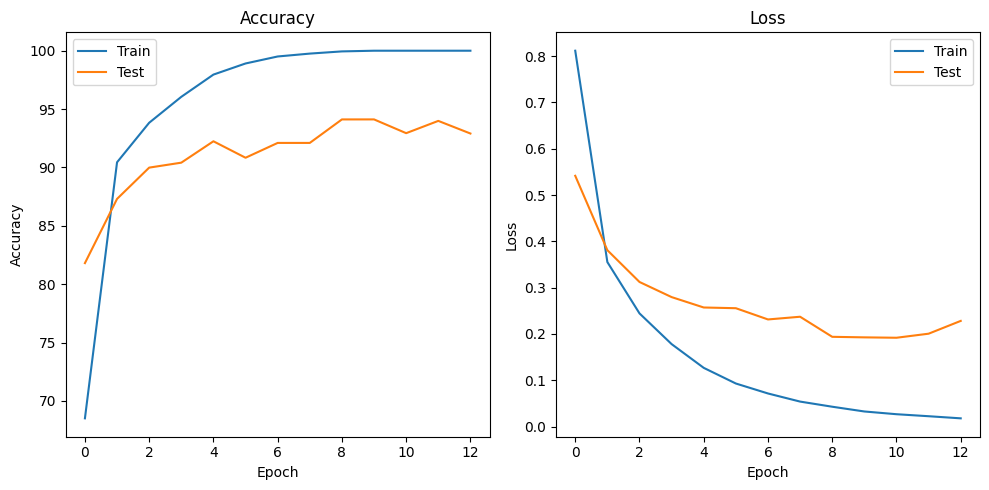

In [12]:
# Plot the train and test accuracy and loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(avg_train_accuracies, label='Train')
ax1.plot(avg_val_accuracies, label='Test')
ax1.set_title('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(avg_train_losses, label='Train')
ax2.plot(avg_val_losses, label='Test')
ax2.set_title('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
# plt.savefig('./Traininglog_pic/cexp_vec20_avg_cnn1_230505.PNG', dpi=300)
plt.show()

In [13]:
print(round(avg_train_accuracies[-1], 2),'%',sep='')
print(round(avg_val_accuracies[-1], 2),'%',sep='')
print(round(avg_train_losses[-1], 2))
print(round(avg_val_losses[-1], 2))

100.0%
92.91%
0.02
0.23


In [14]:
Avg_ac = sum(model_ac_list)/len(model_ac_list)
Avg_pc = sum(model_pc_list)/len(model_pc_list)
Avg_rc = sum(model_rc_list)/len(model_rc_list)
Avg_f1 = sum(model_f1_list)/len(model_f1_list)

print('Avg Model Accuracy: {:.2%}'.format(Avg_ac))
print('Avg Model Precision: {:.2%}'.format(Avg_pc))
print('Avg Model Recall: {:.2%}'.format(Avg_rc))
print('Avg Model F1-score: {:.2%}'.format(Avg_f1))

Avg Model Accuracy: 90.99%
Avg Model Precision: 90.98%
Avg Model Recall: 90.99%
Avg Model F1-score: 90.95%


In [15]:
if Avg_f1 <= 0.90:
    del model
    print("Hazure")
else:
    print("Bingo!")

Bingo!


In [48]:
# del model

In [47]:
# # Save Model Parameter
# torch.save(model, './models/CNN1_vec30sum_90p.pt')
# torch.save(model.state_dict(), './models/cexp60_CNN1_vec25sum_91p_weight.pt')
# # Save NPZ
# X_data = {'X_resampled': np.array(X_resampled)}
# np.savez_compressed('./resampled_vec/cexp60_X_resampled.npz', **X_data)
# y_data = {'y_resampled': np.array(y_resampled)}
# np.savez_compressed('./resampled_vec/cexp60_y_resampled.npz', **y_data)